# Setup

In [26]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.load_footystats import GenerateDataFrame
from data.load_csv import DataLoader
from pipeline.X_table_constructor import XTrainConstructor, XTestConstructor

In [27]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

# Data Pre-processing

In [17]:
stats = df_past10.describe().transpose()[['mean', 'min', 'max', 'std']]
stats = stats.iloc[1:]
home_stats = stats.loc[stats.index.str.contains('H')]
away_stats = stats.loc[stats.index.str.contains('A')]

stats

,mean,min,max,std
FTHG,1.533922,0.0,9.0,1.322083
FTAG,1.223203,0.0,9.0,1.192969
HTHG,0.691551,0.0,5.0,0.853225
HTAG,0.543253,0.0,5.0,0.753035
HS,12.370996,0.0,37.0,5.260501
AS,10.354098,0.0,31.0,4.659194
HST,5.426986,0.0,19.0,2.670905
AST,4.634552,0.0,17.0,2.418785
HC,5.777806,0.0,19.0,3.093532
AC,4.681463,0.0,19.0,2.710031


In [18]:
home_stats.to_csv('home_stats.csv')
away_stats.to_csv('away_stats.csv')

In [10]:
df_past1.columns

# create a table where columns are [Field, Description, Type, Example]
# and fill the table
# save the table as a csv file

names = df_past1.columns
info = [
    ['Date of the match', 'datetime', '2020-01-01'],
    ['Home Team', 'String', 'Liverpool'],
    ['Away Team', 'String', 'Aresenal'],
    ['Full-time Home Goals', 'Integer', 2],
    ['Full-time Away Goals', 'Integer', 1],
    ['Full-time Result', 'String', 'H'],
    ['Half-time Home Goals', 'Integer', 1],
    ['Half-time Away Goals', 'Integer', 0],
    ['Half-time Result', 'String', 'H'],
    ['Home Shots', 'Integer', 10],
    ['Away Shots', 'Integer', 12],
    ['Home Shots on Target', 'Integer', 5],
    ['Away Shots on Target', 'Integer', 7],
    ['Home Corners', 'Integer', 5],
    ['Away Corners', 'Integer', 3],
    ['Home Fouls', 'Integer', 10],
    ['Away Fouls', 'Integer', 12],
    ['Home Yellow Cards', 'Integer', 1],
    ['Away Yellow Cards', 'Integer', 2],
    ['Home Red Cards', 'Integer', 0],
    ['Away Red Cards', 'Integer', 1],
    ['Home Possession %', 'Integer', 65],
    ['Away Possession %', 'Integer', 35],
    ['Home Win Odds', 'Float', 1.5],
    ['Draw Odds', 'Float', 3.0],
    ['Away Win Odds', 'Float', 2.0],
    ['Home xG', 'Float', 1.5],
    ['Away xG', 'Float', 1.0],
    ['Status of the match', 'String', 'Completed'],
]

column_info = pd.DataFrame(info, columns=['Description', 'Type', 'Example'])
column_info.insert(0, 'Field', names, False)

column_info

,Field,Description,Type,Example
0,Date,Date of the match,datetime,2020-01-01
1,HomeTeam,Home Team,String,Liverpool
2,AwayTeam,Away Team,String,Aresenal
3,FTHG,Full-time Home Goals,Integer,2
4,FTAG,Full-time Away Goals,Integer,1
5,FTR,Full-time Result,String,H
6,HTHG,Half-time Home Goals,Integer,1
7,HTAG,Half-time Away Goals,Integer,0
8,HTR,Half-time Result,String,H
9,HS,Home Shots,Integer,10


In [11]:
column_info.to_csv('column_info.csv', index=False)

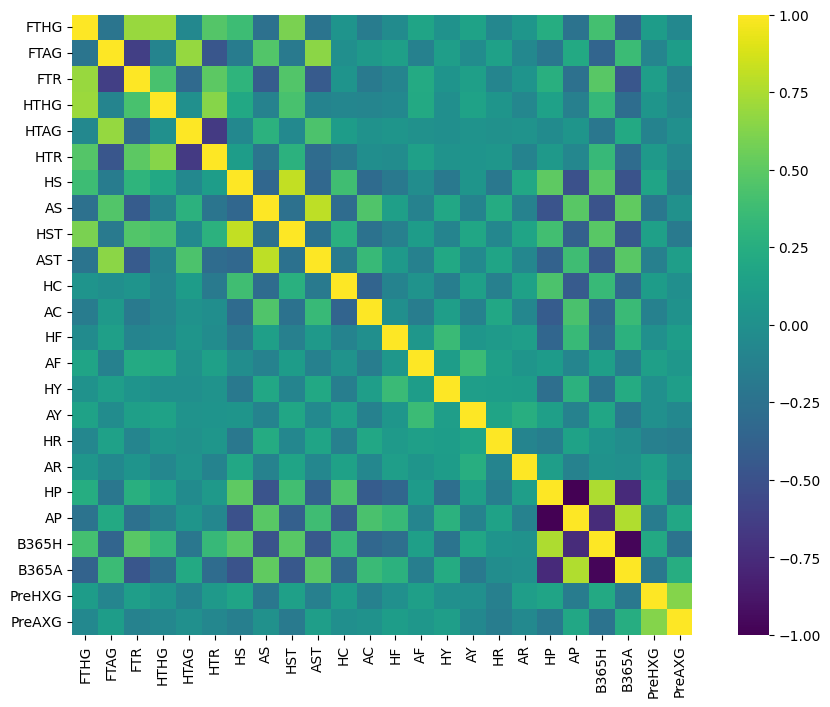

In [55]:
matrix_data = df_past1.copy()
matrix_data.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'Status', 'B365D'], inplace=True)

matrix_data['FTR'] = matrix_data['FTR'].map({'H': 1, 'D': 0, 'A': -1})
matrix_data['HTR'] = matrix_data['HTR'].map({'H': 1, 'D': 0, 'A': -1})

matrix_data['B365H'] = 1 / matrix_data['B365H']
matrix_data['B365A'] = 1 / matrix_data['B365A']

scaler = StandardScaler()
matrix_data = pd.DataFrame(scaler.fit_transform(matrix_data), columns=matrix_data.columns)

corr = matrix_data.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='viridis')
# reduce the height of the scale bar
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(top=0.77)
plt.gca().set_aspect('equal', adjustable='box')
# tight layout

plt.savefig('fb_correlation.pdf')
plt.show()
# save fig

# Feature Engineering

In [3]:
feature_params = {
    Feature.PI_RATINGS.value: True,
    Feature.PI_PAIRWISE.value: True,
    Feature.PI_WEIGHTED.value: True
}

train, test, unique_teams = model.pre_process_data(df_past5)
X_train = XTrainConstructor(train.X, unique_teams, **feature_params).construct_table()

pi_ratings = X_train[['HT', 'AT', 'HT_HomeRating', 'HT_AwayRating', 'AT_HomeRating', 'AT_AwayRating']]
pi_pairwise = X_train[['HT', 'AT', 'PWHT_HomeRating', 'PWHT_AwayRating', 'PWAT_HomeRating', 'PWAT_AwayRating']]
pi_weighted = X_train[['HT', 'AT', 'WPWHT_HomeRating', 'WPWHT_AwayRating', 'WPWAT_HomeRating', 'WPWAT_AwayRating']]
X_train.tail()

,HT,AT,HT_HomeRating,HT_AwayRating,AT_HomeRating,AT_AwayRating,PWHT_HomeRating,PWHT_AwayRating,PWAT_HomeRating,PWAT_AwayRating,WPWHT_HomeRating,WPWHT_AwayRating,WPWAT_HomeRating,WPWAT_AwayRating
1670,Crystal Palace,Liverpool,-0.254519,-0.365293,1.350472,0.824242,-0.502288,0.113153,0.483293,-0.094158,-0.321827,-0.163635,-0.418787,0.606688
1671,Wolverhampton Wanderers,Nottingham Forest,0.107422,-0.368668,-0.185469,-0.609318,0.067026,-0.061662,-0.050932,0.045568,0.056393,-0.163635,-0.418787,-0.307341
1672,Sheffield United,Brentford,-0.900656,-1.214537,0.335671,-0.002683,0.140882,-0.140882,-0.104112,0.104112,-0.450328,-0.163635,-0.418787,-0.001341
1673,Manchester United,AFC Bournemouth,0.502396,0.143777,0.129579,0.034319,0.043740,0.288658,-0.068329,-0.264069,0.417397,-0.163635,-0.418787,-0.149039
1674,Brighton & Hove Albion,Burnley,0.389458,0.313946,-0.652162,-0.505340,-0.081627,-0.109738,0.016453,0.174912,0.099047,-0.156988,0.355644,-0.156988


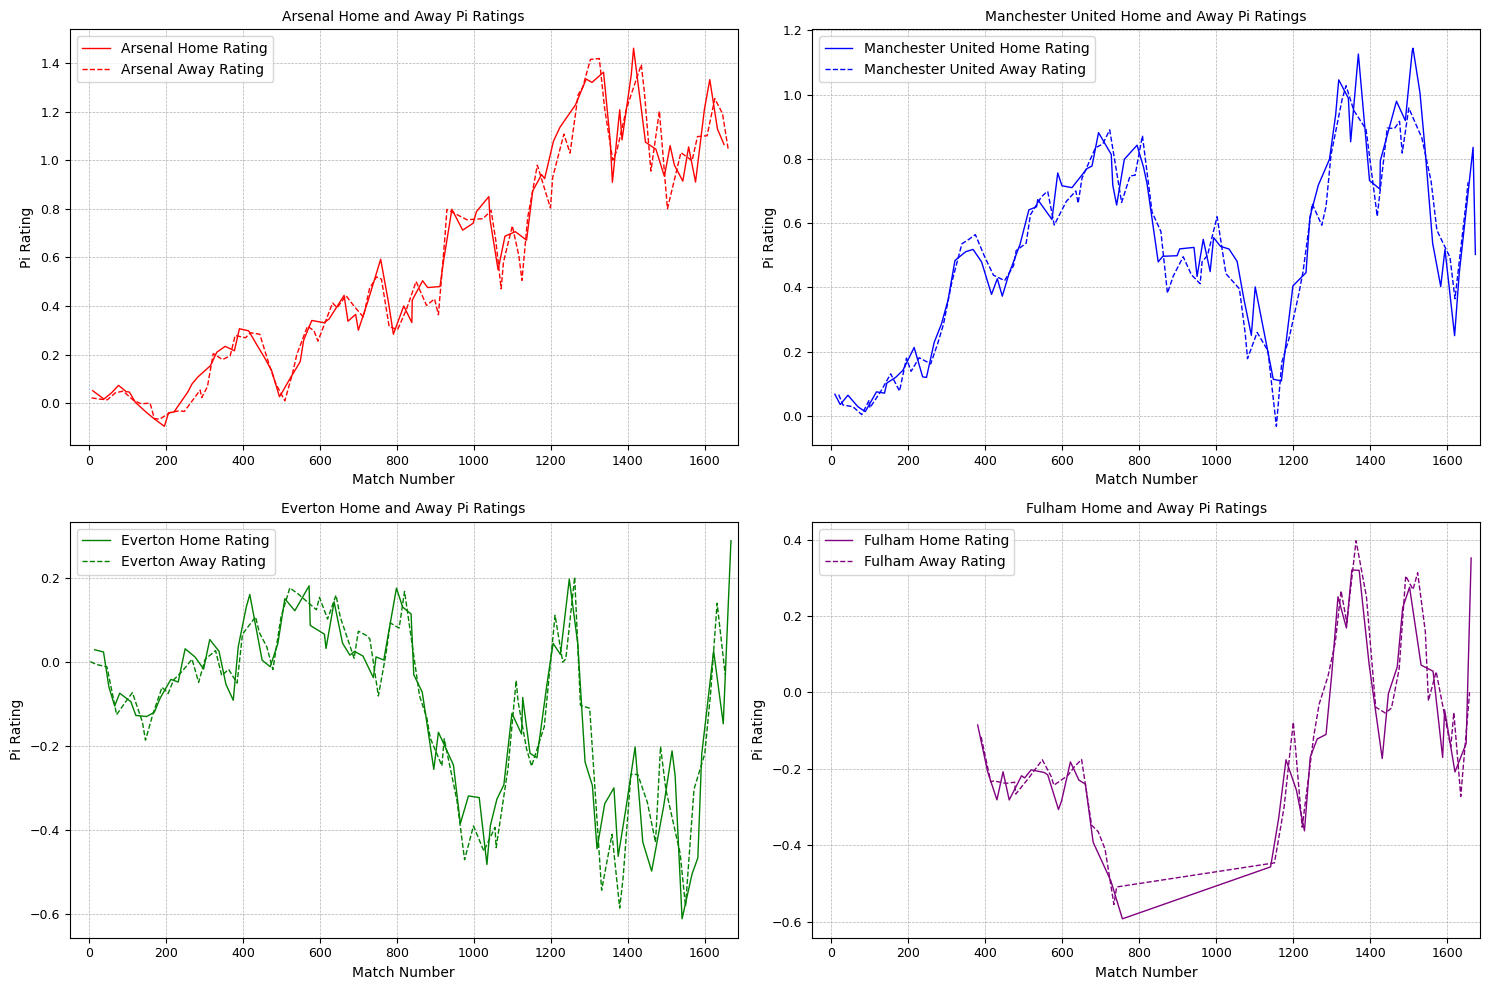

In [4]:
# Plot Pi-ratings
teams = ['Arsenal', 'Manchester United', 'Everton', 'Fulham']
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(15, 10))

for i, team in enumerate(teams):
    team_home = pi_ratings.loc[pi_ratings['HT'] == team]
    team_away = pi_ratings.loc[pi_ratings['AT'] == team]

    # Creating a subplot for each team
    plt.subplot(2, 2, i+1)
    plt.plot(team_home['HT_HomeRating'], label=f'{team} Home Rating', color=colors[i], linewidth=1)
    plt.plot(team_away['AT_HomeRating'], label=f'{team} Away Rating', color=colors[i], linestyle='dashed', linewidth=1)
    
    plt.legend(fontsize='medium')
    plt.title(f'{team} Home and Away Pi Ratings', fontsize=10)
    plt.xlabel('Match Number', fontsize=10)
    plt.ylabel('Pi Rating', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlim(-50, len(df_past5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig('fb_pi_2x2.pdf')
plt.show()

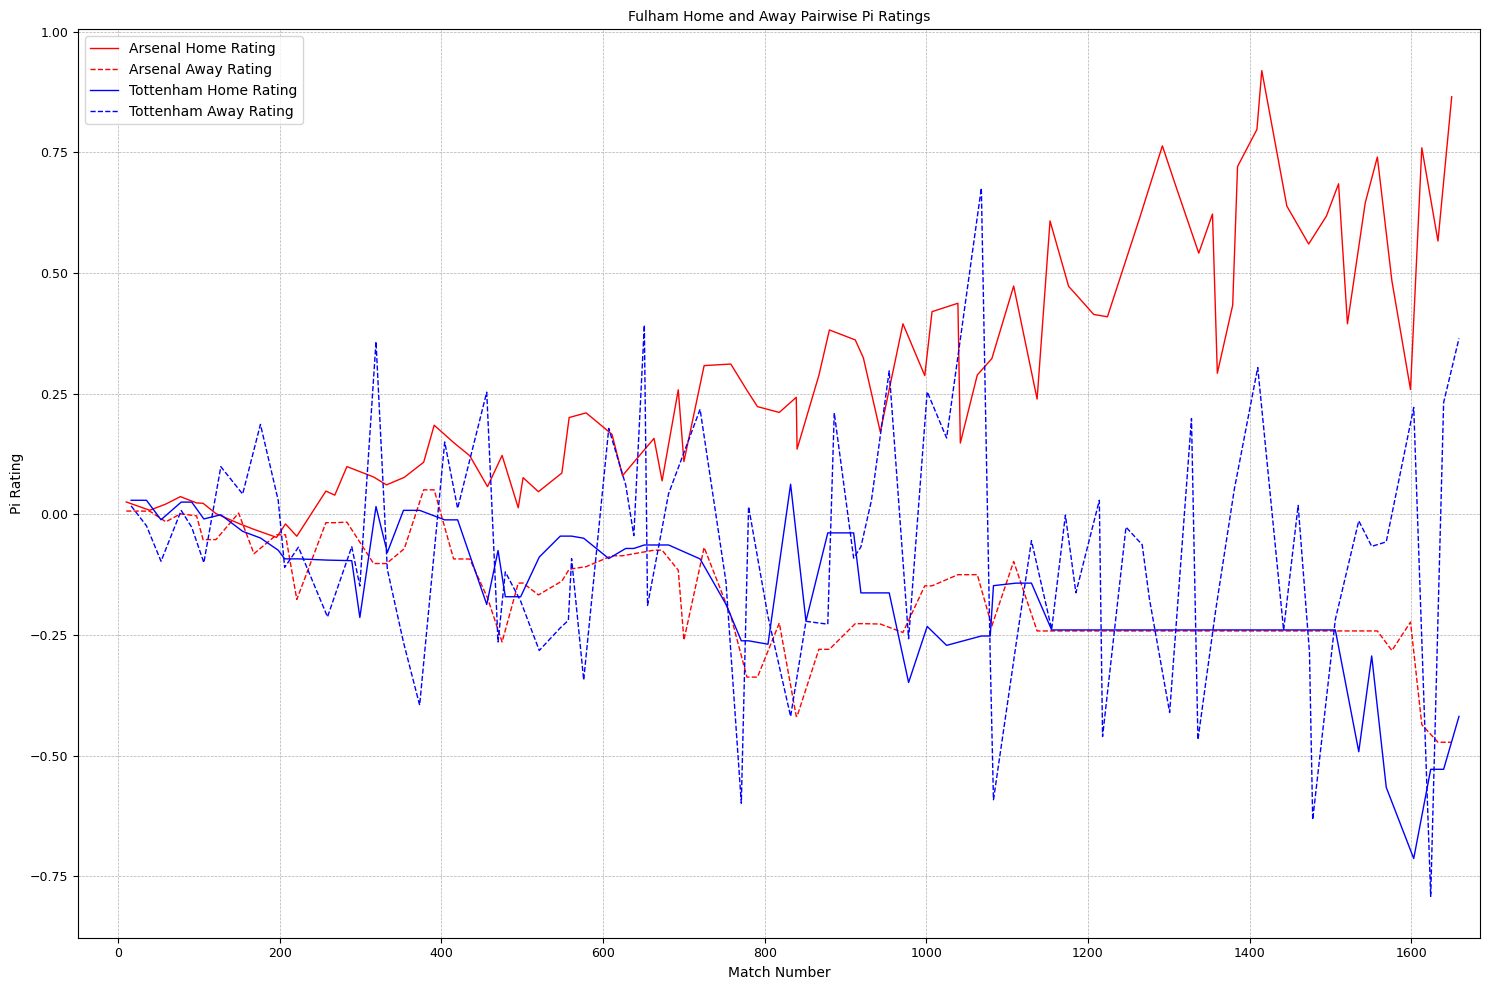

In [14]:
# Plot Pairwise Pi-ratings
plt.figure(figsize=(15, 10))
arsenal = pi_weighted.loc[(pi_weighted['HT'] == 'Arsenal')]
tottenham = pi_weighted.loc[(pi_weighted['HT'] == 'Manchester City')]

plt.plot(arsenal['WPWHT_HomeRating'], label='Arsenal Home Rating', color='red', linewidth=1)
plt.plot(arsenal['WPWHT_AwayRating'], label='Arsenal Away Rating', color='red', linestyle='dashed', linewidth=1)
plt.plot(tottenham['WPWAT_HomeRating'], label='Tottenham Home Rating', color='blue', linewidth=1)
plt.plot(tottenham['WPWAT_AwayRating'], label='Tottenham Away Rating', color='blue', linestyle='dashed', linewidth=1)


plt.legend(fontsize='medium')
plt.title(f'{team} Home and Away Pairwise Pi Ratings', fontsize=10)
plt.xlabel('Match Number', fontsize=10)
plt.ylabel('Pi Rating', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xlim(-50, len(df_past5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('fb_pi_pairwise.pdf')
plt.show()

In [18]:
feature_params = {
    Feature.WIN_STREAK.value: True,
}

train, test, unique_teams = model.pre_process_data(df_past5)
win_streak = XTrainConstructor(train.X, unique_teams, **feature_params).construct_table()
win_streak.tail()

,HT,AT,HT_WinStreak,AT_WinStreak
1670,Crystal Palace,Liverpool,0,3
1671,Wolverhampton Wanderers,Nottingham Forest,0,0
1672,Sheffield United,Brentford,1,0
1673,Manchester United,AFC Bournemouth,0,2
1674,Brighton & Hove Albion,Burnley,0,0


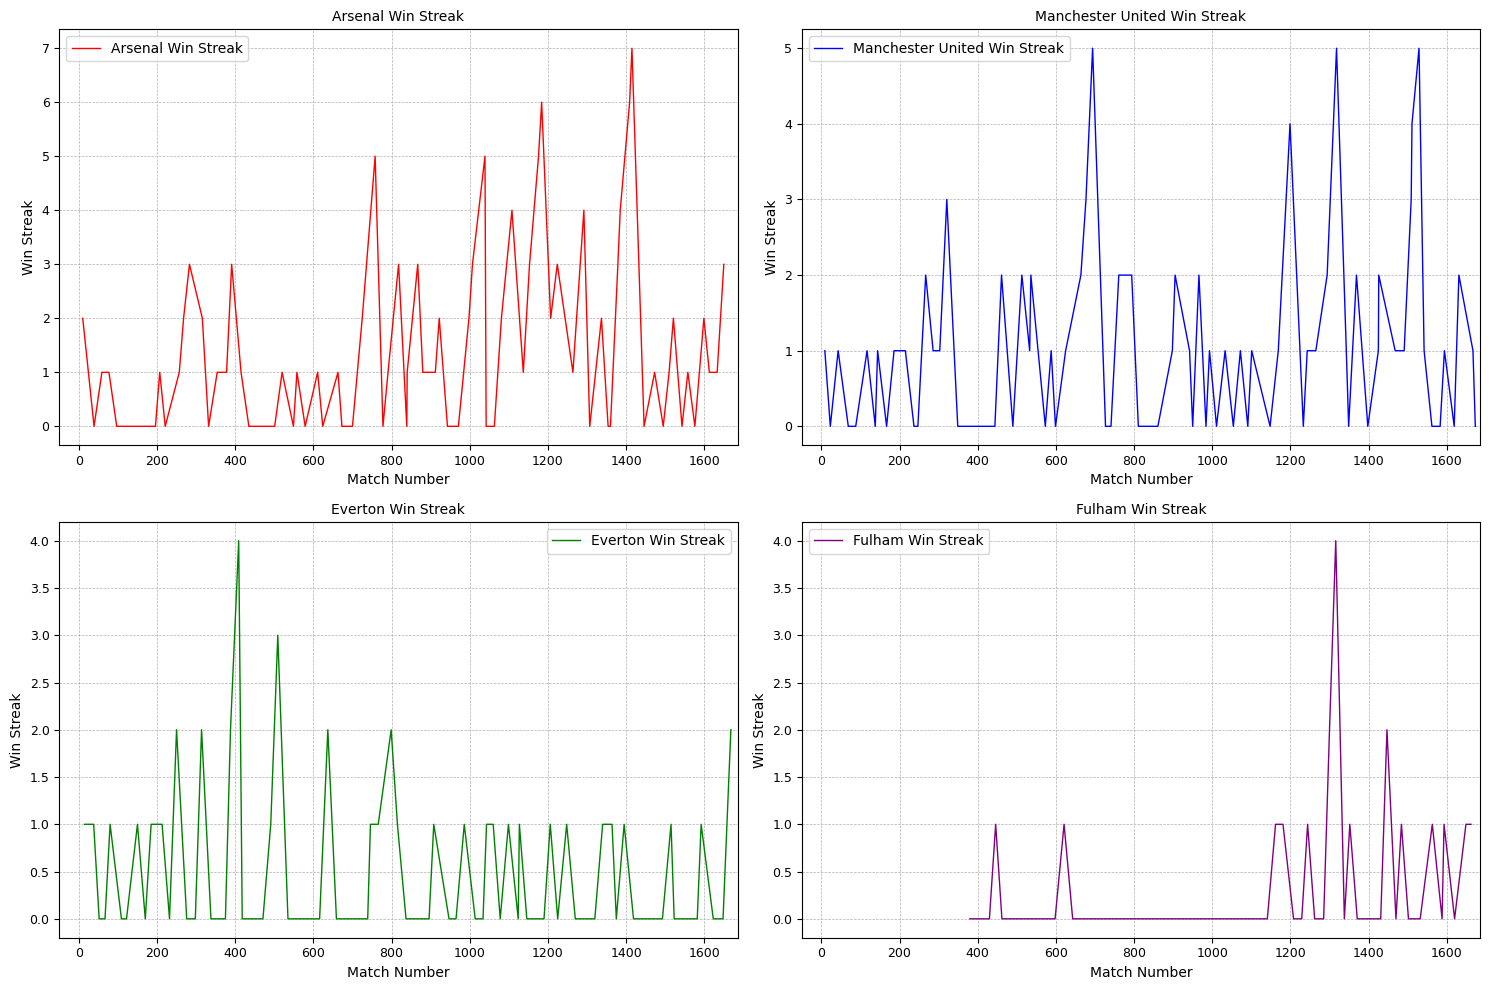

In [25]:
# Plot Win Streak
teams = ['Arsenal', 'Manchester United', 'Everton', 'Fulham']
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(15, 10))

for i, team in enumerate(teams):
    team_win_streak = win_streak.loc[(win_streak['HT'] == team)]

    # Creating a subplot for each team
    plt.subplot(2, 2, i+1)
    plt.plot(team_win_streak['HT_WinStreak'], label=f'{team} Win Streak', color=colors[i], linewidth=1)
    
    plt.legend(fontsize='medium')
    plt.title(f'{team} Win Streak', fontsize=10)
    plt.xlabel('Match Number', fontsize=10)
    plt.ylabel('Win Streak', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlim(-50, len(df_past5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig('fb_win_streak.pdf')
plt.show()

In [29]:
params = {
    Feature.GOAL_STATS.value: False,
    Feature.SHOOTING_STATS.value: False,
    Feature.POSSESSION_STATS.value: False,
    Feature.RESULT.value: False,
    Feature.ODDS.value: False,
    Feature.XG.value: False,
    Feature.HOME_AWAY_RESULTS.value: False,
    Feature.CONCEDED_STATS.value: False,
    Feature.LAST_N_MATCHES.value: False,
    Feature.WIN_STREAK.value: False,
    Feature.PAIRWISE_STATS.value: False,
    Feature.PI_RATINGS.value: True,
    Feature.PI_PAIRWISE.value: False,
    Feature.PI_WEIGHTED.value: False
}

train, test, unique_teams = model.pre_process_data(df_past1)
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, feature_params)

In [30]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm = model.train_model(svm, 'SVM', X_train, y_train, X_test, y_test)

SVM:
[1 0 1 1 1 2 0 0 0 1]
Accuracy: 0.5
F1 Score: 0.3666666666666667
Precision: 0.3833333333333333
Recall: 0.38888888888888884
Cross Validation Accuracy: mean=0.795, std=0.07154

